# Read lengths exploration

In [6]:
from datamap import experiment_files, experiments_dict
from Fast5Fetch.fast5fetch.fast5data import get_all_fast5s
from ont_fast5_api.fast5_interface import get_fast5_file
from matplotlib import pyplot as plt

def get_read_lengths(exp_list):
    exp_lengths = {}
    for k in exp_list:
        file_lengths = {}
        feu_to_index=lambda x: int(x.stem.split('_')[-1])
        covid_to_index=lambda x: int(x.stem[5:])
        if(k in ['pos_2022','pos_2020','neg_2022','neg_2020']):
            index_func = feu_to_index
        else:
            index_func = covid_to_index
        for f in sorted(experiment_files[k], key=index_func):
            # print(f.stem)
            lengths = []
            with get_fast5_file(f, mode='r') as f5:
                for i,read in enumerate(f5.get_reads()):
                    x = read.get_raw_data(scale=True)
                    lengths.append(len(x))
            file_lengths[f.stem]=lengths
        exp_lengths[k]= file_lengths
        print(f'EXP {k} done')
    return exp_lengths



In [7]:
from statistics import mean

def plot_avg_lengths(exp_lengths):
    #TODO add medians
    fig, ax = plt.subplots(figsize=(8,4))
    for j, (exp, file_lengths) in enumerate(exp_lengths.items()):
        means = []
        for i,(k,v) in enumerate(file_lengths.items()):
            means.append(int(mean(v)))
        ax.plot(means, label=exp)

    ax.set_title('READS LENGTHS DIFFERENCES')
    ax.set_ylabel('AVG read length')
    ax.set_xlabel('Experiment file order (suffix number)')
    ax.legend(loc="upper left")


EXP 2-OmeATP_0 done
EXP 2-OmeATP_10 done


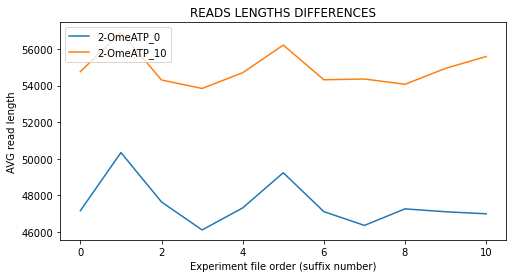

In [8]:
plot_avg_lengths(get_read_lengths(['2-OmeATP_0','2-OmeATP_10']))

# Signal and cutoff exploration

In [63]:
from scipy import stats
import numpy as np
from matplotlib import pyplot as plt
from itertools import islice
from bonito_pulled.bonito.reader import trim
from datamap import experiment_files
import random
from ont_fast5_api.fast5_interface import get_fast5_file
from dataloading import my_trim
from bonito_pulled.bonito.reader import trim




def process_fast5_read(read, window, skip=0, zscore=True, scale=True, smartskip=True, exp_label=None, total_limit=None):
    """ Normalizes and extracts specified region from raw signal """
    
    #zscore normalization matters - computes statistics from the whole sequence
    start = 0
    end = 1000
    cut = False
    stand_before_cut = True
    if(cut and not stand_before_cut):
        s = read.get_raw_data(scale=scale, start=start, end=end)  # Expensive
    else:
        s = read.get_raw_data(scale=scale)  # Expensive
    
    if zscore:
        s = stats.zscore(s)
        
        
    if(smartskip):
        skip, _ = my_trim(signal=s[:26000], window_size=200, threshold=1.9, min_elements=25)
        
        
    if(window):
        pos = random.randint(skip, len(s)-window)
        print('starting position:',pos)
        return s[pos:pos+window].reshape((window, 1))
    if(cut):
        return s[start:end]
    
    if(smartskip):
        cutoffs[exp_label] = skip
        
    if(total_limit):
        return s[:total_limit], skip
    
    return s, skip


def myite(files, window, index, zscore, scale, smartskip, exp_label, total_limit):
    while True:
        fast5 = random.choice(files)
        # fast5 = files[0] #uncomment for deterministic
        with get_fast5_file(fast5, mode='r') as f5:
            #Visualization shows index-th read of the file
            read = next(islice(f5.get_reads(), index, None))
            x, cutoff = process_fast5_read(read, window, zscore=zscore, scale=scale, smartskip=smartskip, exp_label=exp_label, total_limit=total_limit)
            # print('R',Path(fast5).stem)
            yield x.reshape(-1,1).swapaxes(0,1), cutoff
    
def plot_classes_all(exp_list, total_limit=None, index=random.randint(0,100)):
    zscore=True
    scale=True
    smartskip = True
    
    seqs = {}
    cutoffs = {}
    for exp in exp_list:
        
        ite = myite(experiment_files[exp], window=None, index=index, zscore=zscore, scale=scale, smartskip=smartskip, exp_label=exp, total_limit=total_limit) # picking from the first 100 reads
        sample = next(ite)
        seqs[exp] = sample[0][0]
        cutoffs[exp] = sample[1]
    
    fig, axs = plt.subplots(len(exp_list), sharey=True, sharex=True, figsize=(10,len(exp_list)*2.5))
    max_x = max([len(seq) for seq in seqs.values()])
    
    for i,exp in enumerate(exp_list):
        axs[i].plot(seqs[exp])
        axs[i].hlines(y=[-2,2], xmin=0, xmax=max_x, colors='red')
        axs[i].vlines(x=cutoffs[exp], color='purple',ymin=-5, ymax=5)
        axs[i].set_title(exp)
        


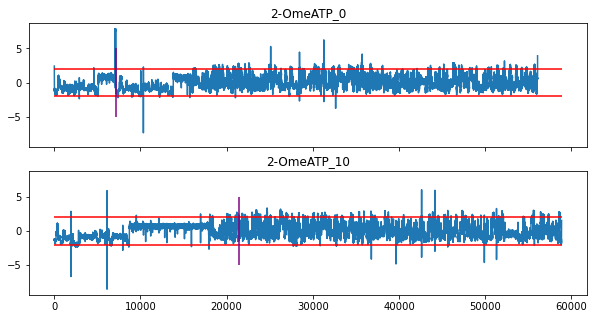

In [64]:
# %%time
import time
from statistics import mean

plot_classes_all(['2-OmeATP_0','2-OmeATP_10'])



# Lengths distribution across labels 

In [61]:
from datamap import experiment_files, experiments_dict
from Fast5Fetch.fast5fetch.fast5data import get_all_fast5s
from ont_fast5_api.fast5_interface import get_fast5_file
from matplotlib import pyplot as plt
import pickle

def precompute_lengths():
    exp_lengths = {}
    for k in experiment_files.keys():
        file_lengths = {}
        
        #TODO remove sorting or add split for covid data
        for f in sorted(experiment_files[k], key=lambda x: int(x.stem.split('_')[-1])):
            print(f.stem)
            lengths = []
            with get_fast5_file(f, mode='r') as f5:
                for i,read in enumerate(f5.get_reads()):
                    x = read.get_raw_data(scale=True)
                    lengths.append(len(x))
            file_lengths[f.stem]=lengths
        exp_lengths[k]= file_lengths
        print(f'EXP {k} done')


    with open('saved_lengths.pkl', 'wb') as f:
        pickle.dump(exp_lengths, f)
        
# with open('saved_lengths.pkl', 'rb') as f:
    # loaded_dict = pickle.load(f)


In [62]:
from statistics import mean
import pandas as pd
import pickle
def get_lengths_df():
    data = []
    with open('saved_lengths.pkl', 'rb') as f:
        loaded_dict = pickle.load(f)
        for exp in loaded_dict.keys():
            print('#'*10, exp)
            subdict = loaded_dict[exp]
            for fast5file in subdict.keys():
                lengths_list = subdict[fast5file]
                for length in lengths_list:
                    datapoint = {
                        'exp':exp,
                        'file':fast5file,
                        'len':length,

                    }
                    data.append(datapoint)
                # print(mean(lengths_list))
    df = pd.DataFrame(data)
    return df



In [66]:
from matplotlib import pyplot as plt

def plot_len_dist(exp_list, df):
    fig, axs = plt.subplots(len(exp_list), sharex=True, sharey=True, figsize=(10,len(exp_list)*2.5))
    plt.ticklabel_format(useOffset=False,style='plain')
    plt.xticks(np.arange(0, 1e7, 5e5))
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    
    for i,exp in enumerate(exp_list):
        sub_df = df[df['exp']==exp]
        lengths = sub_df['len'].values
        axs[i].hist(lengths, bins=50, cumulative=False, log=True, density=False)
        print(f'{exp} max length',max(lengths))


In [67]:
df = get_lengths_df()

########## pos_2022
########## neg_2022
########## pos_2020
########## neg_2020


pos_2022 max length 7973214
neg_2022 max length 10851786


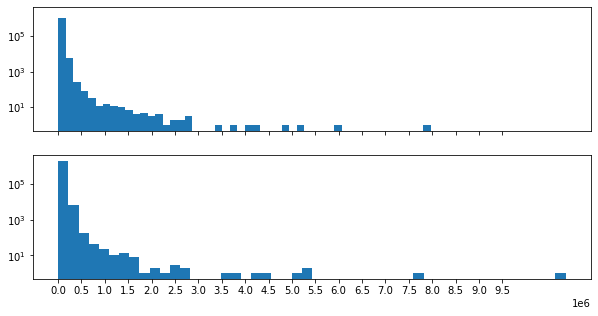

In [68]:
plot_len_dist(['pos_2022','neg_2022'], df)

pos_2020 max length 4565427
neg_2020 max length 3541231


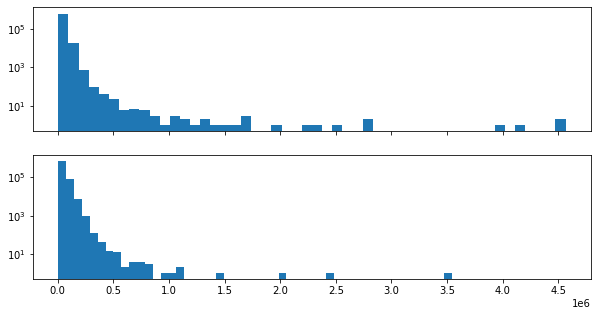

In [69]:
plot_len_dist(['pos_2020','neg_2020'], df)

# Predicting labels based on length

In [31]:
import optuna

optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective_factory(exp1, exp2, aggregate_files=False):
    def objective(trial):
        threshold = trial.suggest_int('x', 0, 1000000)
        pos_sub = df[df['exp'].isin([exp1])]
        neg_sub = df[df['exp'].isin([exp2])]
        
        if(aggregate_files):
            pos_lengths = pos_sub.groupby('file').agg('mean')['len'].values
            neg_lengths = neg_sub.groupby('file').agg('mean')['len'].values
        else:
            pos_lengths = pos_sub['len'].values
            neg_lengths = neg_sub['len'].values
            
        pos_perc = sum(pos_lengths < threshold)/len(pos_lengths)
        neg_perc = sum(neg_lengths > threshold)/len(neg_lengths)
        return (pos_perc+neg_perc)/2
    return objective

def run_threshold(exp1, exp2, trials=250, agg_files=False):
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_factory(exp1, exp2, agg_files), n_trials=trials)

    trial = study.best_trial
    # print("  Value: ", trial.value)
    # print("  Params: ")
    # for key, value in trial.params.items():
    #     print("    {}: {}".format(key, value))
    return trial.value

In [36]:
import itertools
from datamap import experiment_files

def get_length_based_acc(agg_files):
    experiments = experiment_files.keys()
    combs = list(itertools.combinations(experiments, 2))
    results = []
    for exp1, exp2 in combs:
        acc = run_threshold(exp1, exp2, agg_files=agg_files)
        results.append([exp1, exp2, acc])
    return results

In [38]:
readwise_results = get_length_based_acc(agg_files=False)

  Value:  0.5631598394259446
  Params: 
    x: 40721
  Value:  0.5096248272114465
  Params: 
    x: 40880
  Value:  0.5515924234662197
  Params: 
    x: 38899
  Value:  0.500006934887959
  Params: 
    x: 986425
  Value:  0.5007653955554808
  Params: 
    x: 15260
  Value:  0.5425644746227534
  Params: 
    x: 36325


In [39]:
filewise_results = get_length_based_acc(agg_files=True)

  Value:  0.9861013986013987
  Params: 
    x: 43643
  Value:  0.5127272727272727
  Params: 
    x: 42470
  Value:  0.5
  Params: 
    x: 555828
  Value:  0.5
  Params: 
    x: 917213
  Value:  0.5
  Params: 
    x: 835646
  Value:  0.9769622331691297
  Params: 
    x: 43173


In [44]:
readwise_results

[['pos_2022', 'neg_2022', 0.5631598394259446],
 ['pos_2022', 'pos_2020', 0.5096248272114465],
 ['pos_2022', 'neg_2020', 0.5515924234662197],
 ['neg_2022', 'pos_2020', 0.500006934887959],
 ['neg_2022', 'neg_2020', 0.5007653955554808],
 ['pos_2020', 'neg_2020', 0.5425644746227534]]

In [45]:
filewise_results

[['pos_2022', 'neg_2022', 0.9861013986013987],
 ['pos_2022', 'pos_2020', 0.5127272727272727],
 ['pos_2022', 'neg_2020', 0.5],
 ['neg_2022', 'pos_2020', 0.5],
 ['neg_2022', 'neg_2020', 0.5],
 ['pos_2020', 'neg_2020', 0.9769622331691297]]

# Testing heterogenity of batches (OLD)

In [7]:
from torch.utils.data import DataLoader

from dataloading import get_demo_dataset, get_my_dataset
train_dset, valid_dset = get_my_dataset(valid_limit=10, valid_files_count=10, window=1000)
# train_loader = DataLoader(train_dset, batch_size=64)

train_loader = DataLoader(train_dset, batch_size=64, num_workers=32,
                          pin_memory=True, persistent_workers=True)
# valid_loader = DataLoader(valid_dset, batch_size=64, num_workers=32,
#                           pin_memory=True, persistent_workers=True)

train_loader

valid files indicies
[15, 46, 109, 112, 138, 145, 162, 200, 210, 224]
[74, 79, 111, 144, 184, 251, 295, 316, 473, 497]


In [ ]:
#TODO try to evaluate only on samples where threshold <0.1 or >0.9 -> compute accuracy on confident samples only, rest undecided 

In [8]:
loader_iterator = iter(train_loader)
# loader_valid_iterator = iter(valid_loader)
#TODO try also validation set

SKIP too longSKIP too long  SKIP too long76907690  SKIP too long SKIP too long76906845 6845SKIP too longSKIP too long 
SKIP too long7690SKIP too long
  SKIP too long   SKIP too long 6845SKIP too longSKIP too long76907690 7690 6845 7690SKIP too long7690 SKIP too long 
SKIP too long6845SKIP too long SKIP too longSKIP too long  7690
7690
   7690    76907690 769068457690 684576907690 6845 6845  
  6845
 6845
SKIP too long
6845684568457690SKIP too long684568456845


6845 

  

SKIP too long
7690
SKIP too long  7690769076906845    
684568456845
6845


SKIP too long 7690 6845
SKIP too long 7690 6845
SKIP too long 7690 6845
SKIP too long 7690 6845
SKIP too long 7690 6845
SKIP too long 7690 6845
SKIP too long 7690 6845
SKIP too long 7690 6845
SKIP too long 7690 6845


In [9]:
x, y = next(loader_iterator)

In [10]:
import numpy as np
unique, counts = np.unique(y.numpy().flatten(), return_counts=True)
counts


array([34, 30])

In [11]:
unique, counts = np.unique(x.numpy()[:,:,0].flatten(), return_counts=True)
assert(len(counts)) == 64
unique

array([-1.3734828 , -1.3412325 , -1.3369563 , -1.3153783 , -1.2155182 ,
       -1.0326864 , -0.93167347, -0.90613925, -0.82039803, -0.8193726 ,
       -0.75711274, -0.7520199 , -0.7076745 , -0.70751935, -0.6592823 ,
       -0.6256715 , -0.60970014, -0.56676483, -0.5325577 , -0.49009112,
       -0.42002878, -0.41326377, -0.4017004 , -0.31449443, -0.292732  ,
       -0.275979  , -0.26612425, -0.26508838, -0.24041115, -0.21250728,
       -0.20471323, -0.16119187, -0.1474503 , -0.11934522, -0.0610728 ,
       -0.05974193,  0.03523112,  0.05251919,  0.07996623,  0.2541798 ,
        0.3647546 ,  0.3786981 ,  0.4878905 ,  0.6803979 ,  0.771999  ,
        0.82099795,  0.87715524,  0.88317287,  0.89286023,  0.99338144,
        1.0311135 ,  1.0450617 ,  1.0596194 ,  1.1122091 ,  1.1556405 ,
        1.220845  ,  1.2444533 ,  1.2780894 ,  1.2796129 ,  1.3070749 ,
        1.4022031 ,  1.6382208 ,  1.6821312 ,  1.7387931 ], dtype=float32)

In [12]:
iterations = 100
loader_iterator = iter(train_loader)
ratios = []
for i in range(iterations):
    x, y = next(loader_iterator)
    unique, counts = np.unique(y.numpy().flatten(), return_counts=True)
    ratio = counts[0]/counts[1]
    ratios.append(ratio)

#ratio should be 1, oterwise one label is overrepresented
print(sum(ratios)/len(ratios))

1.0216917933529652


In [55]:
def gen():
    while True:
        thresh = random.random()
        if(thresh > 0.5):
            yield 0
        yield 1
        # else:
            # yield 1

it = gen(0.8)

generated_data = []
for _ in range(10):
    generated_data.append(next(it))
generated_data

[0, 1, 0, 1, 0, 1, 0, 1, 0, 1]